In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import open3d as o3d
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import json
from pathlib import Path


class TemplatePoseVisualizer:
    """
    A class to visualize 3D poses of planar templates and camera position in 3D space.
    
    This visualizer takes rotation matrices and translation vectors computed from
    homography decomposition and renders them as 3D quads with a camera frustum.
    """
    
    def __init__(self, template_size: Tuple[float, float] = (1.0, 1.0)):
        """
        Initialize the visualizer.
        
        Args:
            template_size: (width, height) of template quads in 3D units
        """
        self.template_size = template_size
        self.geometries = []  # Store all geometry objects for the scene
        self.textures = [
            os.path.join('..', 'assets', 'templates', 'template_00.jpg'),
            os.path.join('..', 'assets', 'templates', 'template_02.jpg'),
            os.path.join('..', 'assets', 'templates', 'template_03.jpg'),
            os.path.join('..', 'assets', 'templates', 'template_04.jpg'),
        ]
        
    def create_template_quad(self, R: np.ndarray, t: np.ndarray, 
                           color: Tuple[float, float, float] = (0.7, 0.7, 0.9)) -> o3d.geometry.TriangleMesh:
        """
        Create a 3D quad representing a template at the given pose.
        
        The template is created as a rectangle in the XY plane, then transformed
        according to the rotation matrix R and translation vector t.
        
        Args:
            R: 3x3 rotation matrix (camera to template)
            t: 3x1 translation vector (camera to template)
            color: RGB color tuple for the quad
            
        Returns:
            Open3D TriangleMesh representing the template quad
        """
        # Validate inputs
        assert R.shape == (3, 3), f"Rotation matrix must be 3x3, got {R.shape}"
        assert t.shape == (3, 1) or t.shape == (3,), f"Translation vector must be 3x1 or (3,), got {t.shape}"
        
        # Ensure t is a column vector
        if t.shape == (3,):
            t = t.reshape(3, 1)
            
        # Create template vertices in local coordinate system (centered at origin)
        # Template lies in XY plane with Z=0
        w, h = self.template_size
        local_vertices = np.array([
            [-w/2, -h/2, 0],  # Bottom-left
            [ w/2, -h/2, 0],  # Bottom-right  
            [ w/2,  h/2, 0],  # Top-right
            [-w/2,  h/2, 0]   # Top-left
        ]).T  # Shape: (3, 4)
        
        # Transform vertices to world coordinates using R and t
        # World coordinates = R * local_coordinates + t
        world_vertices = R @ local_vertices + t
        
        # Create Open3D mesh
        mesh = o3d.geometry.TriangleMesh()
        
        # Set vertices (transpose back to (N, 3) format for Open3D)
        mesh.vertices = o3d.utility.Vector3dVector(world_vertices.T)
        
        # Define triangles (two triangles to form a quad)
        # Triangle 1: vertices 0, 1, 2
        # Triangle 2: vertices 0, 2, 3
        triangles = np.array([
            [0, 1, 2],
            [0, 2, 3]
        ])
        mesh.triangles = o3d.utility.Vector3iVector(triangles)
        
        # Set color
        mesh.paint_uniform_color(color)
        
        # Compute normals for proper lighting
        mesh.compute_vertex_normals()
        
        return mesh
    
    def create_camera_frustum(self, focal_length: float = 1.0, 
                            image_size: Tuple[int, int] = (640, 480),
                            frustum_scale: float = 0.3,
                            color: Tuple[float, float, float] = (1.0, 0.0, 0.0)) -> o3d.geometry.LineSet:
        """
        Create a camera frustum to represent the camera position and orientation.
        
        The camera is positioned at the origin looking down the negative Z-axis
        (standard computer vision convention).
        
        Args:
            focal_length: Camera focal length in pixels
            image_size: (width, height) of the image in pixels
            frustum_scale: Scale factor to make frustum visible
            color: RGB color for the frustum lines
            
        Returns:
            Open3D LineSet representing the camera frustum
        """
        # Camera intrinsic parameters
        width, height = image_size
        cx, cy = width / 2, height / 2  # Principal point (image center)
        
        # Near and far plane distances
        near = 0.1 * frustum_scale
        far = 2.0 * frustum_scale
        
        # Calculate frustum corners in camera coordinates
        # Camera looks down -Z axis, so frustum extends in -Z direction
        
        # Near plane corners
        near_x = near * (width / 2) / focal_length
        near_y = near * (height / 2) / focal_length
        
        # Far plane corners  
        far_x = far * (width / 2) / focal_length
        far_y = far * (height / 2) / focal_length
        
        # Define frustum vertices
        vertices = np.array([
            # Camera center (apex of frustum)
            [0, 0, 0],
            
            # Near plane corners (closer to camera)
            [-near_x, -near_y, -near],  # Top-left
            [ near_x, -near_y, -near],  # Top-right
            [ near_x,  near_y, -near],  # Bottom-right
            [-near_x,  near_y, -near],  # Bottom-left
            
            # Far plane corners (further from camera)
            [-far_x, -far_y, -far],     # Top-left
            [ far_x, -far_y, -far],     # Top-right
            [ far_x,  far_y, -far],     # Bottom-right
            [-far_x,  far_y, -far]      # Bottom-left
        ])
        
        # Define lines connecting the vertices
        lines = [
            # Lines from camera center to near plane corners
            [0, 1], [0, 2], [0, 3], [0, 4],
            
            # Near plane rectangle
            [1, 2], [2, 3], [3, 4], [4, 1],
            
            # Lines from near plane to far plane
            [1, 5], [2, 6], [3, 7], [4, 8],
            
            # Far plane rectangle
            [5, 6], [6, 7], [7, 8], [8, 5]
        ]
        
        # Create Open3D LineSet
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(vertices)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        
        # Set color for all lines
        colors = [color for _ in range(len(lines))]
        line_set.colors = o3d.utility.Vector3dVector(colors)
        
        return line_set
    
    def create_coordinate_frame(self, size: float = 0.5) -> o3d.geometry.TriangleMesh:
        """
        Create a coordinate frame to show the world origin and axes orientation.
        
        Args:
            size: Length of the coordinate axes
            
        Returns:
            Open3D TriangleMesh representing XYZ axes
        """
        return o3d.geometry.TriangleMesh.create_coordinate_frame(size=size)
    
    def add_templates(self, rotations: List[np.ndarray], translations: List[np.ndarray],
                     colors: Optional[List[Tuple[float, float, float]]] = None):
        """
        Add multiple templates to the scene.
        
        Args:
            rotations: List of 3x3 rotation matrices
            translations: List of 3x1 translation vectors
            colors: Optional list of RGB colors for each template
        """
        assert len(rotations) == len(translations), "Number of rotations and translations must match"
        
        if colors is None:
            # Generate distinct colors for each template
            colors = []
            for i in range(len(rotations)):
                hue = (i * 360 / len(rotations)) % 360
                colors.append(self._hsv_to_rgb(hue, 0.8, 0.9))
        
        assert len(colors) == len(rotations), "Number of colors must match number of templates"
        
        # Create and store template quads
        for i, (R, t, color) in enumerate(zip(rotations, translations, colors)):
            quad = self.create_template_quad(R, t, color)
            self.geometries.append(quad)
            print(f"Added template {i+1}/{len(rotations)} at position {t.flatten()}")
    
    def _hsv_to_rgb(self, h: float, s: float, v: float) -> Tuple[float, float, float]:
        """Convert HSV color to RGB."""
        import colorsys
        return colorsys.hsv_to_rgb(h/360, s, v)
    
    def visualize(self, show_camera: bool = True, show_coordinate_frame: bool = True,
                 camera_params: Optional[dict] = None, method: str = 'matplotlib'):
        """
        Visualize the complete 3D scene with templates and camera.
        
        Args:
            show_camera: Whether to show the camera frustum
            show_coordinate_frame: Whether to show coordinate axes at origin
            camera_params: Dictionary with camera parameters for frustum creation
            method: Visualization method ('matplotlib', 'html', 'export', 'gui', 'auto')
                   'matplotlib' works reliably in WSL and Jupyter
        """
        if show_camera:
            # Use default camera parameters if not provided
            if camera_params is None:
                camera_params = {
                    'focal_length': 500.0,
                    'image_size': (640, 480),
                    'frustum_scale': 0.5
                }
            
            camera_frustum = self.create_camera_frustum(**camera_params)
            self.geometries.append(camera_frustum)
            print("Added camera frustum")
        
        if show_coordinate_frame:
            coord_frame = self.create_coordinate_frame()
            self.geometries.append(coord_frame)
            print("Added coordinate frame")
        
        if not self.geometries:
            print("Warning: No geometries to display!")
            return
        
        print(f"Visualizing scene with {len(self.geometries)} objects...")
        
        # Choose visualization method
        if method == 'matplotlib':
            self._matplotlib_visualization()
        elif method == 'html':
            self._html_visualization()
        elif method == 'export':
            self._export_scene()
        elif method == 'gui':
            self._gui_visualization()
        elif method == 'auto':
            if not self._try_gui_visualization():
                print("GUI failed, trying matplotlib...")
                self._matplotlib_visualization()
        else:
            raise ValueError(f"Unknown visualization method: {method}")
    
    def _matplotlib_visualization(self):
        """
        Create a 3D visualization using matplotlib - works reliably in WSL.
        """
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')
        
        print("Creating matplotlib 3D visualization...")
        
        # Process each geometry
        for i, geom in enumerate(self.geometries):
            if isinstance(geom, o3d.geometry.TriangleMesh):
                self._add_mesh_to_matplotlib(ax, geom, f"Mesh_{i}")
            elif isinstance(geom, o3d.geometry.LineSet):
                self._add_lineset_to_matplotlib(ax, geom, f"Lines_{i}")
        
        # Set up the plot
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Template Pose Visualization')
        
        # Set equal aspect ratio
        self._set_equal_aspect_3d(ax)
        
        # Add legend
        ax.legend()
        
        print("Controls:")
        print("- Mouse: Rotate view")
        print("- Scroll: Zoom")
        print("- Close window when done")
        
        plt.tight_layout()
        plt.show()
    
    def _add_mesh_to_matplotlib(self, ax, mesh: o3d.geometry.TriangleMesh, label: str):
        """Add a triangle mesh to matplotlib 3D plot."""
        vertices = np.asarray(mesh.vertices)
        triangles = np.asarray(mesh.triangles)
        colors = np.asarray(mesh.vertex_colors)
        
        # If no colors, use a default color based on label
        if len(colors) == 0:
            if "camera" in label.lower() or "coordinate" in label.lower():
                color = 'red' if "camera" in label.lower() else 'black'
            else:
                # Generate color based on mesh index
                color_map = plt.cm.tab10
                color = color_map(hash(label) % 10)
        else:
            color = colors[0] if len(colors) > 0 else 'blue'
        
        # Create 3D polygon collection
        poly3d = []
        for triangle in triangles:
            poly3d.append(vertices[triangle])
        
        collection = Poly3DCollection(poly3d, alpha=0.7, linewidths=0.5, edgecolors='black')
        collection.set_facecolor(color)
        ax.add_collection3d(collection)
        
        # Add to legend (use first triangle center as representative point)
        if len(triangles) > 0:
            center = vertices[triangles[0]].mean(axis=0)
            ax.scatter(*center, color=color, s=0, label=label)  # Invisible point for legend
    
    def _add_lineset_to_matplotlib(self, ax, lineset: o3d.geometry.LineSet, label: str):
        """Add a line set to matplotlib 3D plot."""
        points = np.asarray(lineset.points)
        lines = np.asarray(lineset.lines)
        colors = np.asarray(lineset.colors)
        
        # Default color for lines
        if len(colors) == 0:
            color = 'red' if 'camera' in label.lower() else 'blue'
        else:
            color = colors[0] if len(colors) > 0 else 'blue'
        
        # Plot each line
        for i, line in enumerate(lines):
            start_point = points[line[0]]
            end_point = points[line[1]]
            
            ax.plot3D([start_point[0], end_point[0]],
                     [start_point[1], end_point[1]],
                     [start_point[2], end_point[2]],
                     color=color, linewidth=2, 
                     label=label if i == 0 else "")  # Only label first line
    
    def _set_equal_aspect_3d(self, ax):
        """Set equal aspect ratio for 3D plot."""
        # Get the range of each axis
        all_points = []
        for geom in self.geometries:
            if isinstance(geom, o3d.geometry.TriangleMesh):
                all_points.extend(np.asarray(geom.vertices))
            elif isinstance(geom, o3d.geometry.LineSet):
                all_points.extend(np.asarray(geom.points))
        
        if not all_points:
            return
            
        all_points = np.array(all_points)
        
        # Calculate ranges
        x_range = [all_points[:, 0].min(), all_points[:, 0].max()]
        y_range = [all_points[:, 1].min(), all_points[:, 1].max()]
        z_range = [all_points[:, 2].min(), all_points[:, 2].max()]
        
        # Find the maximum range
        max_range = max(x_range[1] - x_range[0], 
                       y_range[1] - y_range[0], 
                       z_range[1] - z_range[0])
        
        # Calculate centers
        x_center = (x_range[0] + x_range[1]) / 2
        y_center = (y_range[0] + y_range[1]) / 2
        z_center = (z_range[0] + z_range[1]) / 2
        
        # Set equal limits
        ax.set_xlim(x_center - max_range/2, x_center + max_range/2)
        ax.set_ylim(y_center - max_range/2, y_center + max_range/2)
        ax.set_zlim(z_center - max_range/2, z_center + max_range/2)
    
    def _html_visualization(self, filename: str = "template_visualization.html"):
        """
        Create an HTML file with interactive 3D visualization using Three.js.
        """
        print(f"Creating HTML visualization: {filename}")
        
        # Extract geometry data
        meshes_data = []
        lines_data = []
        
        for i, geom in enumerate(self.geometries):
            if isinstance(geom, o3d.geometry.TriangleMesh):
                vertices = np.asarray(geom.vertices).tolist()
                triangles = np.asarray(geom.triangles).tolist()
                colors = np.asarray(geom.vertex_colors)
                
                # Default color if none specified
                if len(colors) == 0:
                    if i == 0:  # First mesh (template)
                        color = [0.7, 0.7, 0.9]
                    else:
                        color = [0.5, 0.8, 0.5]
                else:
                    color = colors[0].tolist()
                
                meshes_data.append({
                    'vertices': vertices,
                    'triangles': triangles,
                    'color': color,
                    'name': f'Mesh_{i}',
                    'texture': self.textures[i % len(self.textures)] if i < len(self.textures) else None
                })
                
            elif isinstance(geom, o3d.geometry.LineSet):
                points = np.asarray(geom.points).tolist()
                lines = np.asarray(geom.lines).tolist()
                colors = np.asarray(geom.colors)
                
                # Default color for lines (red for camera)
                if len(colors) == 0:
                    color = [1.0, 0.0, 0.0]  # Red for camera frustum
                else:
                    color = colors[0].tolist()
                
                lines_data.append({
                    'points': points,
                    'lines': lines,
                    'color': color,
                    'name': f'Lines_{i}'
                })
        
        # Create HTML content
        html_content = self._generate_html_template(meshes_data, lines_data)
        
        # Write to file
        with open(filename, 'w') as f:
            f.write(html_content)
        
        print(f"HTML visualization saved to {filename}")
        print("Open this file in your web browser to view the 3D scene")
        print("Controls: Mouse to rotate, scroll to zoom, right-click to pan")
    
    def _generate_html_template(self, meshes_data: List, lines_data: List) -> str:
        """Load external HTML template and inject JSON data."""
        tpl = Path(os.path.join(project_root, 'assets', 'visualization_template.html.tpl'))
        html = tpl.read_text()
        return html.replace("{ meshes_json }", json.dumps(meshes_data)) \
                .replace("{ lines_json }",  json.dumps(lines_data))
    
    def _try_gui_visualization(self) -> bool:
        """
        Try GUI visualization, return True if successful, False otherwise.
        """
        try:
            return self._gui_visualization()
        except Exception as e:
            print(f"GUI visualization failed: {e}")
            return False
    
    def _gui_visualization(self) -> bool:
        """
        Traditional GUI-based visualization using Open3D's native window.
        """
        try:
            vis = o3d.visualization.Visualizer()
            success = vis.create_window(window_name="Template Pose Visualization", 
                                      width=1024, height=768)
            
            if not success:
                print("Failed to create visualization window")
                return False
            
            for geom in self.geometries:
                vis.add_geometry(geom)
            
            # Set up a good initial viewpoint
            ctr = vis.get_view_control()
            if ctr is not None:
                ctr.set_front([0.5, 0.5, -1])  # Look direction
                ctr.set_lookat([0, 0, 0])      # Look at origin
                ctr.set_up([0, -1, 0])         # Up direction
                ctr.set_zoom(0.8)
            
            print("Controls:")
            print("- Mouse: Rotate, pan, zoom")
            print("- Press 'Q' or close window to exit")
            
            # Run the visualizer
            vis.run()
            vis.destroy_window()
            return True
            
        except Exception as e:
            print(f"GUI visualization error: {e}")
            return False
    
    def _web_visualization(self):
        """
        Web-based visualization - now creates HTML file instead of using Open3D web viewer.
        """
        print("Open3D web viewer not available in WSL, creating HTML file instead...")
        self._html_visualization()
    
    def _export_scene(self, filename: str = "template_scene.ply"):
        """
        Export the scene to a file that can be viewed in external software.
        """
        print(f"Exporting scene to {filename}...")
        
        # Combine all meshes into one for export
        combined_mesh = o3d.geometry.TriangleMesh()
        
        for geom in self.geometries:
            if isinstance(geom, o3d.geometry.TriangleMesh):
                combined_mesh += geom
            elif isinstance(geom, o3d.geometry.LineSet):
                # Convert LineSet to thin cylinders for better visualization
                mesh_from_lines = self._lineset_to_mesh(geom)
                combined_mesh += mesh_from_lines
        
        # Export to PLY format (widely supported)
        success = o3d.io.write_triangle_mesh(filename, combined_mesh)
        
        if success:
            print(f"Scene exported successfully to {filename}")
            print("You can view this file in:")
            print("- MeshLab (free)")
            print("- Blender (free)")
            print("- Online viewers like: https://3dviewer.net/")
        else:
            print("Failed to export scene")
    
    def _lineset_to_mesh(self, line_set: o3d.geometry.LineSet, 
                        radius: float = 0.01) -> o3d.geometry.TriangleMesh:
        """
        Convert a LineSet to a TriangleMesh using thin cylinders.
        This helps when exporting to formats that don't support lines.
        """
        combined_mesh = o3d.geometry.TriangleMesh()
        
        points = np.asarray(line_set.points)
        lines = np.asarray(line_set.lines)
        
        for line in lines:
            start_point = points[line[0]]
            end_point = points[line[1]]
            
            # Create cylinder between the two points
            height = np.linalg.norm(end_point - start_point)
            
            if height > 1e-6:  # Avoid degenerate cylinders
                cylinder = o3d.geometry.TriangleMesh.create_cylinder(
                    radius=radius, height=height, resolution=8
                )
                
                # Position and orient the cylinder
                direction = (end_point - start_point) / height
                center = (start_point + end_point) / 2
                
                # Create rotation matrix to align cylinder with line direction
                z_axis = np.array([0, 0, 1])
                if np.abs(np.dot(direction, z_axis)) < 0.999:
                    rotation_axis = np.cross(z_axis, direction)
                    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
                    angle = np.arccos(np.dot(z_axis, direction))
                    rotation_matrix = self._rotation_matrix_from_axis_angle(rotation_axis, angle)
                else:
                    rotation_matrix = np.eye(3)
                
                # Transform cylinder
                cylinder.rotate(rotation_matrix, center=[0, 0, 0])
                cylinder.translate(center)
                
                combined_mesh += cylinder
        
        return combined_mesh
    
    def _rotation_matrix_from_axis_angle(self, axis: np.ndarray, angle: float) -> np.ndarray:
        """Create rotation matrix from axis-angle representation."""
        # Rodrigues' rotation formula
        axis = axis / np.linalg.norm(axis)  # Normalize
        K = np.array([[0, -axis[2], axis[1]],
                     [axis[2], 0, -axis[0]],
                     [-axis[1], axis[0], 0]])
        
        R = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * (K @ K)
        return R


def test_all_visualization_methods():
    """
    Test all visualization methods (matplotlib, html, export) using synthetic template poses.
    This is useful for verifying compatibility (e.g., with WSL) and ensuring each visualization works as expected.
    """
    import numpy as np

    # --- Define synthetic rotation matrices and translation vectors ---

    # Example 1: 30° rotation around Y-axis, forward translation
    R1 = np.array([
        [np.cos(np.pi / 6), 0, np.sin(np.pi / 6)],
        [0, 1, 0],
        [-np.sin(np.pi / 6), 0, np.cos(np.pi / 6)]
    ])
    t1 = np.array([0, 0, -3]).reshape(3, 1)

    # Example 2: 45° rotation around X-axis, diagonal translation
    R2 = np.array([
        [1, 0, 0],
        [0, np.cos(np.pi / 4), -np.sin(np.pi / 4)],
        [0, np.sin(np.pi / 4), np.cos(np.pi / 4)]
    ])
    t2 = np.array([2, 1, -2]).reshape(3, 1)

    # Example 3: 60° rotation around Z-axis, negative translation
    R3 = np.array([
        [np.cos(np.pi / 3), -np.sin(np.pi / 3), 0],
        [np.sin(np.pi / 3), np.cos(np.pi / 3), 0],
        [0, 0, 1]
    ])
    t3 = np.array([-1, -1, -2]).reshape(3, 1)

    # Group all poses into lists
    rotations = [R1, R2, R3]
    translations = [t1, t2, t3]

    # --- Camera intrinsic parameters and visualization settings ---
    camera_params = {
        'focal_length': 500.0,        # Focal length in pixels
        'image_size': (640, 480),     # Image resolution (width, height)
        'frustum_scale': 0.3          # Scale of camera frustum for visualization
    }

    # --- Create the visualizer and add all synthetic poses ---
    visualizer = TemplatePoseVisualizer(template_size=(1.0, 0.7))  # Width x Height of template
    visualizer.add_templates(rotations, translations)

    # --- Try all supported visualization methods ---
    methods = ['matplotlib', 'html', 'export']
    print("=== Testing all visualization methods ===")
    for method in methods:
        print(f"\nTesting {method} method...")
        try:
            # Attempt to visualize with the given method
            visualizer.visualize(camera_params=camera_params, method=method)

            # Provide feedback based on method
            if method == 'html':
                print("✓ HTML method works! Check 'template_visualization.html'")
            elif method == 'export':
                print("✓ Export method works! Check 'template_scene.ply'")
            else:
                print("✓ Matplotlib method works!")

        except Exception as e:
            print(f"✗ {method.capitalize()} method failed: {e}")



def wsl_setup_instructions():
    """
    Print instructions for setting up GUI support in WSL (if needed).
    """
    print("=== WSL GUI Setup Instructions ===")
    print()
    print("If you want to use GUI visualization in WSL, you have several options:")
    print()
    print("Option 1: Use WSL2 with WSLg (Windows 11)")
    print("- Make sure you're using WSL2: wsl --set-version <distro> 2")
    print("- Install WSLg: should be automatic in Windows 11")
    print()
    print("Option 2: Use X11 forwarding")
    print("- Install X server on Windows (e.g., VcXsrv, Xming)")
    print("- Export DISPLAY variable: export DISPLAY=:0")
    print("- Start X server with 'Disable access control' option")
    print()
    print("Option 3: Use web-based visualization (recommended)")
    print("- Use method='web' in the visualize() call")
    print("- Works with any browser")
    print()
    print("Option 4: Export and view externally")
    print("- Use method='export' to save as .ply file")
    print("- View in MeshLab, Blender, or online viewers")
    print()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


=== Template Pose Visualizer - WSL Compatible ===

Testing all visualization methods...
Added template 1/3 at position [ 0  0 -3]
Added template 2/3 at position [ 2  1 -2]
Added template 3/3 at position [-1 -1 -2]
=== Testing all visualization methods ===

Testing matplotlib method...
Added camera frustum
Added coordinate frame
Visualizing scene with 5 objects...
Creating matplotlib 3D visualization...
Controls:
- Mouse: Rotate view
- Scroll: Zoom
- Close window when done


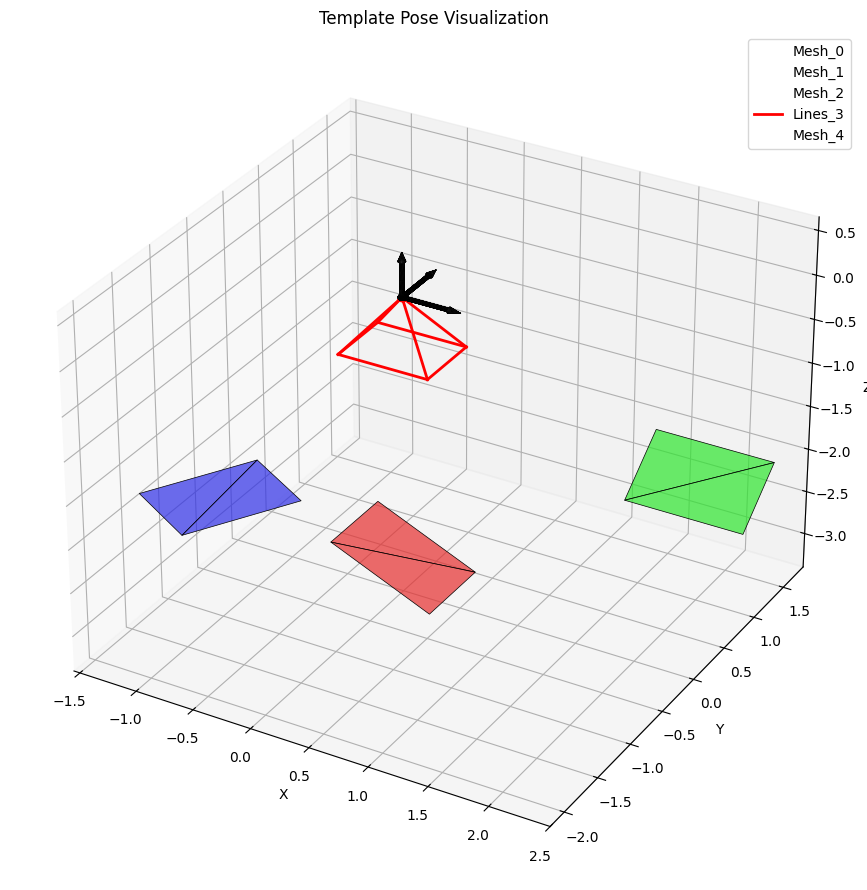

✓ Matplotlib method works!

Testing html method...
Added camera frustum
Added coordinate frame
Visualizing scene with 7 objects...
Creating HTML visualization: template_visualization.html
HTML visualization saved to template_visualization.html
Open this file in your web browser to view the 3D scene
Controls: Mouse to rotate, scroll to zoom, right-click to pan
✓ HTML method works! Check 'template_visualization.html'

Testing export method...
Added camera frustum
Added coordinate frame
Visualizing scene with 9 objects...
Exporting scene to template_scene.ply...
Scene exported successfully to template_scene.ply
You can view this file in:
- MeshLab (free)
- Blender (free)
- Online viewers like: https://3dviewer.net/
✓ Export method works! Check 'template_scene.ply'


In [3]:
print("=== Template Pose Visualizer - WSL Compatible ===")
print()

# Test what works
print("Testing all visualization methods...")
test_all_visualization_methods()